In [ ]:
import numpy as np
import torch
from transformers import VideoMAEForPreTraining, VideoMAEImageProcessor

# 1. 加载预训练的 VideoMAE 模型和图像处理器
model_name = "MCG-NJU/videomae-base"
model = VideoMAEForPreTraining.from_pretrained(model_name)
processor = VideoMAEImageProcessor.from_pretrained(model_name)

# 2. 准备数据和掩码
num_frames = 16
channels = 3
height = 224
width = 224

# 创建示例数据和掩码
data = np.random.randn(num_frames, channels, height, width).astype(np.float32) #* 16,3,224,224

# 强制数据在 [0, 1] 范围内
data = np.clip(data, 0, 1)

# 确保数据通道顺序为 [frames, height, width, channels]
data = data.transpose(0, 2, 3, 1)#* 16,224,224,3

# 将数据和掩码转换为 PyTorch 的 Tensor
pixel_values = processor(images=list(data), return_tensors="pt", do_rescale=False).pixel_values
#* 16,[3,224,224]
# 计算掩码的形状和序列长度
num_patches_per_frame = (model.config.image_size // model.config.patch_size) ** 2 #* (224//16)**2=196
tubelet_seq_length = num_frames//model.config.tubelet_size#! tubelet_size:The number of tubelets

# 随机生成掩码（0表示缺失区域）
bool_masked_pos = torch.randint(0, 2, (1,num_patches_per_frame*tubelet_seq_length)).bool()# generate a array which shape is (1,seq_lem) and its range between (0,1)

# 3. 使用模型进行推理，得到编码后的特征表示
model.eval()
with torch.no_grad():
    outputs = model(pixel_values, bool_masked_pos=bool_masked_pos) # Patches are flattened and embedded into vectors.
    #! model pre-processing pixel_values [1, 16, 3, 224, 224] to [1,1568,768] ==[1,1568,16*16*3]==[batch_size,tubelet_size,patch_size]
    encoded_features = outputs.logits #* batch_size,embedded_seq_length,hidden_size -> 1,variant,1536
    #! the embedded_seq_length would change depending on how many patches were masked.
#! Spatiotemporal Consistency: The model does not shuffle or lose the order of patches during processing, 
#! so any reconstruction attempt (e.g., decoding or projecting back to the pixel space) 
#! should preserve the original spatial and temporal relationships between patches.
# 4. 调整输入形状，确保其形状为 [batch_size, seq_length, feature_dim]
# encoded_features = encoded_features.view(1, -1, model.config.hidden_size) # model.config.hidden_size=768
projection_layer = torch.nn.Linear(outputs.logits.shape[2], 384)# hidden_size decoder typically epected is 384
#! Linear Layer allows for learning and adjusting weights to best fit the data.
# 5. 使用 decoder 进行解码
#! the model's decoding process handles the reconstruction.
decoded_frames = model.decoder(projection_layer(outputs.logits), return_token_num=tubelet_seq_length*num_patches_per_frame)
#* 1, 712, 1536
linear_layer = torch.nn.Linear(1536, 3 * 14 * 14)  # Project to patch size
projected_patches = linear_layer(decoded_frames.logits)  # Shape: (1, 748, 768)
projected_patches = projected_patches.view(1,-1, 3, 14, 14)  # Shape: (1, 773, 3, 16, 16)
num_frames_reconstructed = projected_patches.shape[1] // tubelet_seq_length
reconstructed_video = torch.zeros(1, num_frames_reconstructed, 3, 224, 224)


In [1]:
import numpy as np
import os
import glob
import netCDF4 as nc
from torch.utils.data import DataLoader, Dataset
import torch
def load_data_from_directory(directory, scale_factor=1.0):
    file_paths = glob.glob(f'{directory}/*.nc')
    all_data = []
    all_masks = []
    
    for file_path in file_paths:
        dataset = nc.Dataset(file_path, 'r')
        file_name = os.path.basename(file_path)
        prefix = file_name.split('.')[0]
        data_var = dataset.variables[prefix][:]  # Adjust if needed
        data_var = np.expand_dims(data_var, axis=1)
        mask_var = dataset.variables['mask'][:]
        mask_var = np.expand_dims(mask_var, axis=0)
        missing_value = dataset.variables[prefix]._FillValue

        # Handle missing values
        mask = (mask_var == 1).astype(np.float32)
        data_var[data_var == missing_value] = 0
        data_var = np.nan_to_num(data_var, nan=0.0)

        # Apply scaling factor to the data
        data_var *= scale_factor
        all_data.append(data_var)
        all_masks.append(mask)

        dataset.close()

    # Combine all bands with a new channel dimension

    all_data = np.concatenate(all_data, axis=1)  # Merge all bands into channel dimension
    all_masks = np.concatenate(all_masks, axis=0)
    # Reshape data to fit [batch, time, channels, height, width]
    # all_data = np.expand_dims(all_data, axis=0) # [samples, time, channels, height, width]
    # all_masks = np.expand_dims(all_masks, axis=0) # [samples, channels, height, width]

    return all_data, all_masks
class OceanDataset(Dataset):
    len_frame=1
    def __init__(self, data,mask, use_random_mask=False, mask_ratio=0.0):
        self.data = data # [time, channels, height, width]
        self.mask = mask # [time, channels, height, width]
        self.use_random_mask = use_random_mask
        self.mask_ratio = mask_ratio

    def __len__(self,len_frame=len_frame):
        return int(self.data.shape[0]/len_frame)  # Number of sample

    def __getitem__(self, idx,len_frame=len_frame): #? The size and range of idx depend on the __len__
        data_sample = self.data[idx*len_frame:(idx+1)*len_frame, :, :]  # Take the first 4 time frames [channels, time, height, width]
        mask_sample = self.mask[0, :, :]  # Corresponding mask frames

        # Convert to torch tensor
        data_sample = torch.tensor(data_sample, dtype=torch.float32)
        mask_sample = torch.tensor(mask_sample, dtype=torch.float32)

        # Generate mask based on data_sample
        if self.use_random_mask:
            random_mask = torch.rand_like(mask_sample) < self.mask_ratio
            mask_sample = torch.max(mask_sample, random_mask.float())

        meta_data = (data_sample == 0).float()
        return data_sample, mask_sample, meta_data
    
# Load the data_var,mask #* (24,9,49,46) (9,49,46)
data_var, mask = load_data_from_directory('G:/YuJinYuan-Experiment/MODIS')
# Create dataset and Dataloader
dataset = OceanDataset(data_var,mask ,use_random_mask=False, mask_ratio=0.1)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False) #? batch_size=1:it does automatically add an extra dimension 

torch.Size([4, 50, 50])


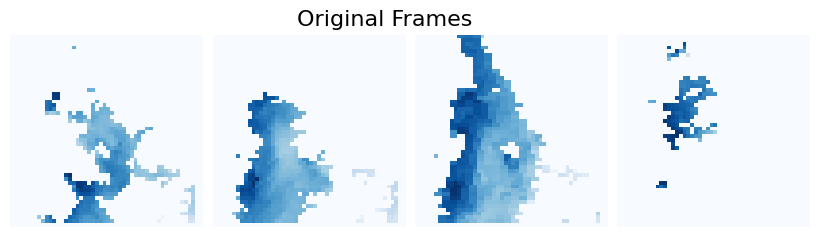

torch.Size([4, 50, 50])


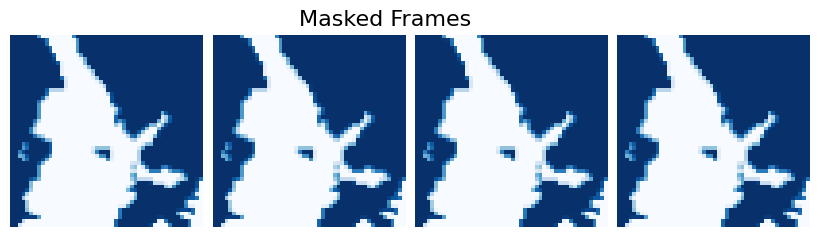

torch.Size([4, 50, 50])


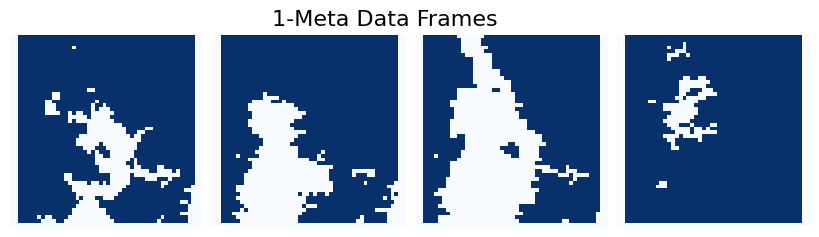

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import torch
import torch.nn.functional as F

def show_sequence(seq, sample=1, title=''):
    # seq should be [num_frames, height, width, num_channels]
    print(seq.shape)
    fig = plt.figure(figsize=(20, 2.5))
    fig.suptitle(title, fontsize=16)
    
    grid = ImageGrid(fig, 111, nrows_ncols=(1, sample), axes_pad=0.1)
    
    for ax, img in zip(grid, seq):
        img = img.squeeze()  # Remove the channel dimension for grayscale images
        ax.imshow((img * 10000), cmap='Blues')
        ax.set_axis_off()
    
    plt.show()
    return
def resize_tensor(tensor, target_size,mode,align_corners):
    # tensor shape: (batch_size, frames, channels, height, width)
    # target_size: tuple of (new_height, new_width)
    
    _, _, _, current_height, current_width = tensor.shape
    target_height, target_width = target_size
    
    # Calculate padding
    pad_height = max(0, target_height - current_height)
    pad_width = max(0, target_width - current_width)
    
    # Calculate padding for each side
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left
    
    # Pad the tensor
    padded_tensor = F.pad(tensor, (pad_left, pad_right, pad_top, pad_bottom))
    
    return padded_tensor
num_frames_to_show = 24
now_frame=0
orig_frames = []
masked_frames = []
meta_data_frames = []

for data_sample, mask_sample, meta_data in dataloader:
    # print(data_sample.shape, mask_sample.shape, meta_data.shape)  # Should output torch.Size([1, 4, 10, 49, 46])
    data_sample=resize_tensor(data_sample, (50, 50),'bilinear', False)
    mask_sample=mask_sample.view(-1,mask_sample.shape[-3],mask_sample.shape[-2],mask_sample.shape[-1])
    mask_sample=F.interpolate(mask_sample, size=(50, 50), mode='bilinear', align_corners=False)
    mask_sample=mask_sample.view(mask_sample.shape[-3],mask_sample.shape[-2],mask_sample.shape[-1])
    meta_data=resize_tensor(meta_data, (50, 50),'bilinear', False)

    # Collect frames within the valid range
    if now_frame < num_frames_to_show:
        orig_frames.append(data_sample[:, :, :, :, :].detach())
        masked_frames.append(mask_sample[:, :].detach())
        meta_data_frames.append(meta_data[:, :, :, :, :].detach())
        now_frame=now_frame+1
    else:
        break

# Convert lists to tensors
orig_frames = torch.cat(orig_frames, dim=1)
masked_frames = torch.cat(masked_frames, dim=0)
meta_data_frames = torch.cat(meta_data_frames, dim=1)

# Visualize frames
show_sequence(orig_frames[0,:4,0,:,:], sample=4, title='Original Frames')
show_sequence(1-masked_frames[:4,:,:], sample=4, title='Masked Frames')
show_sequence(meta_data_frames[0,:4,0,:,:], sample=4, title='1-Meta Data Frames')


In [3]:
orig_frames[:,:,:1,:,:].shape

torch.Size([1, 24, 1, 50, 50])

In [4]:
import torch
import av
import numpy as np
from transformers import AutoImageProcessor, VideoMAEForPreTraining, VideoMAEConfig
from huggingface_hub import hf_hub_download
import torchvision.transforms as transforms
from PIL import Image
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the VideoMAE model for pre-training
config = VideoMAEConfig(
    image_size=50,
    patch_size=2,
    num_channels=1,
    num_frames=24,
    tubelet_size=1,
    hidden_size=768,
    num_hidden_layers=12,
    num_attention_heads=12,
    intermediate_size=3072,
    hidden_act="gelu",
    hidden_dropout_prob=0.0,
    attention_probs_dropout_prob=0.0,
    initializer_range=0.02,
    layer_norm_eps=1e-12,
    qkv_bias=True,
    use_mean_pooling=True
)
# Function to read and sample video frames (provided)
def read_video_pyav(container, indices):
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="gray") for x in frames])

def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

# Download and extract frames from the video
file_path = hf_hub_download(repo_id="nielsr/video-demo", filename="eating_spaghetti.mp4", repo_type="dataset")
container = av.open(file_path)

# Sample 24(num_frames) frames (matching the original input tensor shape)
indices = sample_frame_indices(clip_len=config.num_frames, frame_sample_rate=1, seg_len=container.streams.video[0].frames)
video_frames = read_video_pyav(container, indices)

def read_video(frames, frame_size):
    # Define the transformation pipeline
    transform = transforms.Compose([
        transforms.Resize(frame_size),
        transforms.Grayscale(num_output_channels=config.num_channels),#TODO when channels is one
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        transforms.Normalize(mean=[0.485], std=[0.229])#TODO when channels is one
    ])

    # Convert each frame (which is a NumPy array) to a PIL Image and apply the transformations
    processed_frames = torch.stack([transform(Image.fromarray(frame)) for frame in frames])
    
    return processed_frames

processed_input = read_video(video_frames, (config.image_size, config.image_size))
#TODO replace OceanDataset
input_tensor = orig_frames[:,:,:1,:,:].to(device)
# input_tensor = processed_input.unsqueeze(0).to(device)#* Tensor (1,16,3,112,112)
#TODO set first frame all white
# input_tensor[0, 0, :, :, :] = 1.0

#!only receive image_size of (224,224)
# # Initialize the image processor from the pretrained model 
# image_processor = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base")
# # Process the video frames into a tensor
# processed_input = image_processor(images=list(video_frames), return_tensors="pt")
# input_tensor = processed_input.pixel_values


model = VideoMAEForPreTraining(config).to(device)

# Create a mask for missing values
num_patches_per_frame = (config.image_size // config.patch_size) ** 2
#! seq_length:patch number of a tubelet
seq_length = (config.num_frames // config.tubelet_size) * num_patches_per_frame

bool_masked_pos = torch.randint(0, 2, (1, seq_length)).bool().to(device)#* Tensor (1,seq_length)
#! one tubelet only use one masking strategy
#TODO bool_masked_pos = torch.rand((1, config.num_frames // config.tubelet_size, config.image_size // config.patch_size, config.image_size // config.patch_size)) < 0.3
#TODO bool_masked_pos = bool_masked_pos.view(1, -1).bool()

# Forward pass through the model using the preprocessed video frames
outputs = model(pixel_values=input_tensor, bool_masked_pos=bool_masked_pos)

# The output contains the loss and reconstructed patches
loss = outputs.loss
reconstructed_patches = outputs.logits

# Display the loss and shape of the reconstructed patches
print("Loss:", loss.item())
print("Reconstructed patches shape:", reconstructed_patches.shape)


c:\Users\1\.conda\envs\ViT\Lib\site-packages\transformers\models\videomae\modeling_videomae.py:286: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(


Loss: 0.36079469323158264
Reconstructed patches shape: torch.Size([1, 7463, 4])


In [93]:
from einops import rearrange
patch_size=(config.patch_size,config.patch_size)
orig_frames = input_tensor.permute(0,1,3,4,2).cpu()
img_squeeze = rearrange(
    orig_frames.numpy(), 
    'b (t p0) (h p1) (w p2) c -> b (t h w) (p0 p1 p2) c', 
    p0=config.tubelet_size, p1=patch_size[0], p2=patch_size[1]
)
img_mean = np.mean(img_squeeze, axis=-2, keepdims=True)
img_variance = np.var(img_squeeze, axis=-2, ddof=1, keepdims=True)
img_norm = (img_squeeze - img_mean) / (np.sqrt(img_variance) + 1e-6)
img_patch = rearrange(img_norm, 'b n p c -> b n (p c)')
img_patch[bool_masked_pos.cpu()] = reconstructed_patches.cpu().detach().numpy()
rec_img = rearrange(img_patch, 'b n (p c) -> b n p c', c=config.num_channels)
# Notice: To visualize the reconstruction video, 
# we add the predict and the original mean and var of each patch.
img_mean = np.mean(img_squeeze, axis=-2, keepdims=True)
img_std = np.sqrt(np.var(img_squeeze, axis=-2, ddof=1, keepdims=True) + 1e-6) 
rec_img = rec_img * img_std + img_mean
rec_img = rearrange(
    rec_img, 
    'b (t h w) (p0 p1 p2) c -> b (t p0) (h p1) (w p2) c', 
    p0=config.tubelet_size, p1=patch_size[0], p2=patch_size[1], h=config.image_size//config.patch_size, w=config.image_size//config.patch_size
)
print(rec_img.shape)
reconstructed_video=rec_img

mask=np.ones_like(img_patch)
mask[bool_masked_pos.cpu()]=0
mask=rearrange(mask,'b n (p c)->b n p c',c=config.num_channels)
mask=rearrange(
    mask,
    'b (t h w) (p0 pl p2) c->b (t p0) (h pl) (w p2) c',
    p0=config.tubelet_size,pl=patch_size[0],p2=patch_size[1],h=config.image_size//config.patch_size, w=config.image_size//config.patch_size)

(1, 24, 50, 50, 1)


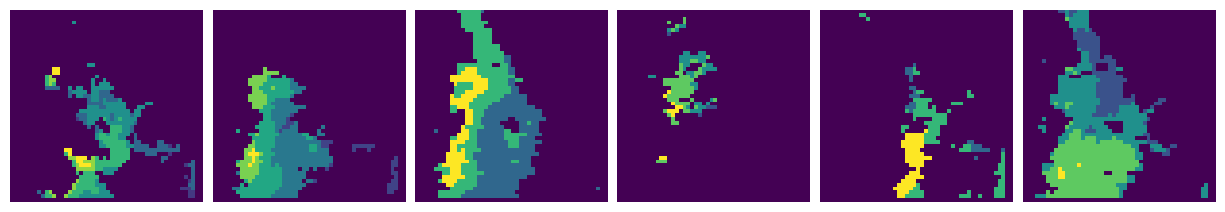

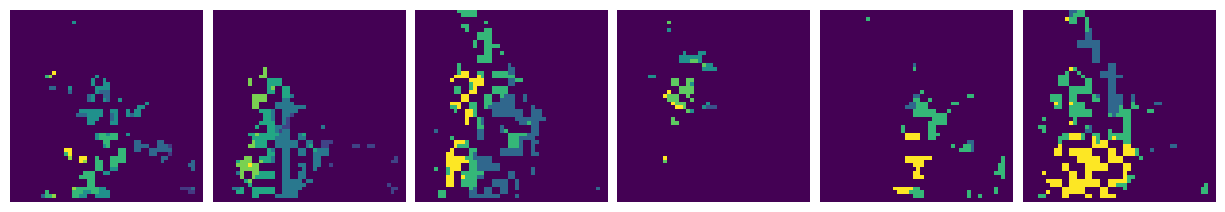

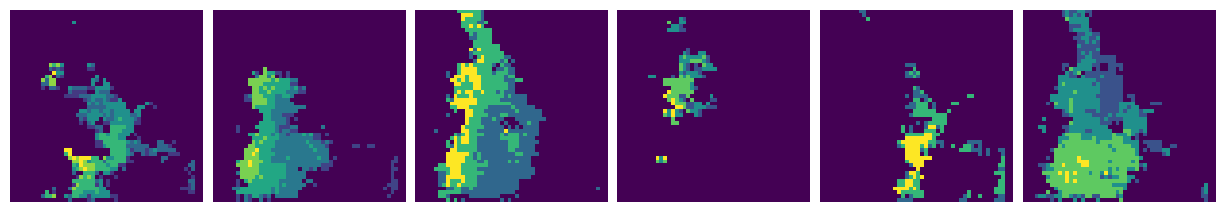

In [92]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
IMAGENET_STD=np.array([0.225,0.225,0.225])
IMAGENET_MEAN=np.array([0.45,0.45,0.45])
def show_sequence(seq,sample=8,title=''):

    assert (seq.shape[-1]==config.num_channels)
    fig =plt.figure(figsize=(20,2.5))
    fig.suptitle(title,fontsize=16)
    grid=ImageGrid(fig,111,nrows_ncols=(1,sample),axes_pad=0.1)
    for ax,img in zip(grid,seq):
        # img=img*IMAGENET_STD+IMAGENET_MEAN
        # img=img*100
        ax.imshow((img*255).clip(0,255).astype ('uint8'))
        ax.set_axis_off()
    plt.show()
    return

show_sequence(orig_frames.numpy()[0],sample=6)
show_sequence(orig_frames.numpy()[0]*mask[0], sample=6)
show_sequence(rec_img[0],sample=6)


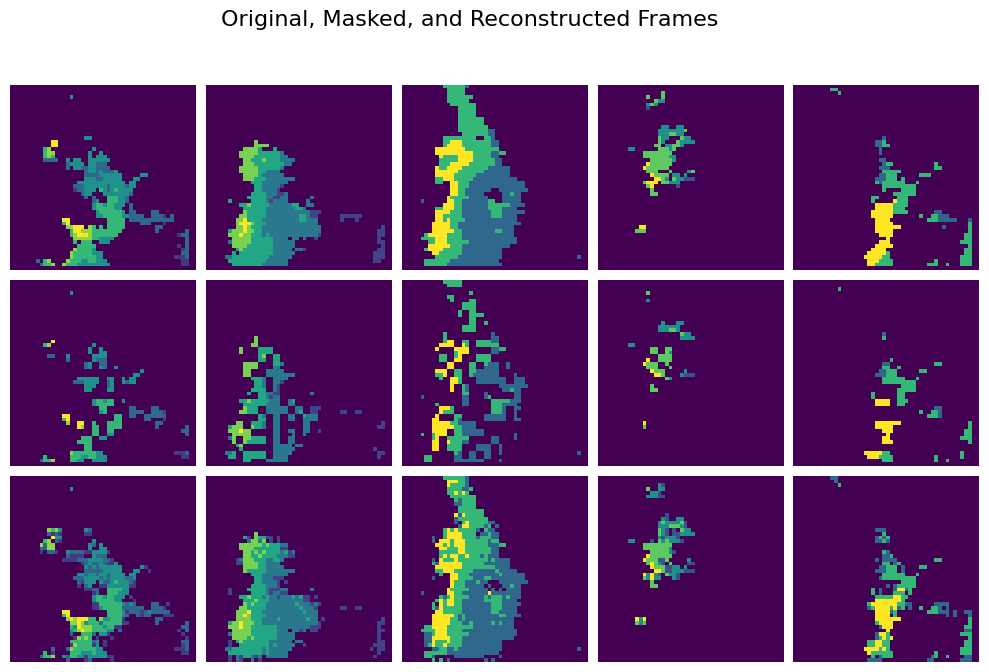

In [95]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

IMAGENET_STD = np.array([0.225, 0.225, 0.225])
IMAGENET_MEAN = np.array([0.45, 0.45, 0.45])

def show_sequence(seq_list, sample=8, title='', save_path=None):
    """
    seq_list: List of sequences to show together.
    sample: Number of frames to show per sequence.
    title: Title of the figure.
    save_path: File path to save the image.
    """
    fig = plt.figure(figsize=(20, len(seq_list) * 2.5))
    fig.suptitle(title, fontsize=16)

    grid = ImageGrid(fig, 111, nrows_ncols=(len(seq_list), sample), axes_pad=0.1)

    for i, seq in enumerate(seq_list):
        for ax, img in zip(grid[i*sample:(i+1)*sample], seq):
            # img = img * IMAGENET_STD + IMAGENET_MEAN  # Uncomment for normalization
            ax.imshow((img * 255).clip(0, 255).astype('uint8'))
            ax.set_axis_off()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)

    plt.show()

# Usage example
show_sequence([orig_frames.numpy()[0], orig_frames.numpy()[0] * mask[0], rec_img[0]], 
            sample=5, 
            title='Original, Masked, and Reconstructed Frames',
            save_path='output_image.png')


In [ ]:
import torch
import torch.nn.functional as F

# Assuming `reconstructed_patches` and `input_tensor` are already defined
# Unflatten the logits
batch_size, num_masked_patches, flattened_patch_dim = reconstructed_patches.shape
patch_size = config.patch_size
num_channels = config.num_channels
tubelet_size = config.tubelet_size

# Compute the number of patches per frame and number of frames
num_patches_per_frame = (config.image_size // patch_size) ** 2
num_frames = config.num_frames

# Reshape the logits
reconstructed_patches2 = reconstructed_patches.view(
    #* 1.1514124870300293-1.1513104438781738-1.1516104936599731-1.1505827903747559
    #* -1.151930809020996-1.1523127555847168-1.1507432460784912
    # batch_size, num_masked_patches, tubelet_size, patch_size, patch_size, num_channels
    # batch_size, num_masked_patches, tubelet_size, num_channels,patch_size, patch_size
    # batch_size, num_masked_patches,patch_size, patch_size, tubelet_size, num_channels
    # batch_size, num_masked_patches,patch_size, patch_size, num_channels,tubelet_size
    # batch_size, num_masked_patches,patch_size, patch_size, tubelet_size,num_channels
    # batch_size, num_masked_patches,num_channels,patch_size, patch_size,tubelet_size
    batch_size, num_masked_patches,num_channels,tubelet_size,patch_size, patch_size
)
# reconstructed_patches2=reconstructed_patches2.permute(0,1,2,4,5,3)
# reconstructed_patches2=reconstructed_patches2.permute(0,1,4,2,3,5)
# reconstructed_patches2=reconstructed_patches2.permute(0,1,5,2,3,4)
# reconstructed_patches2=reconstructed_patches2.permute(0,1,4,2,3,5)
# reconstructed_patches2=reconstructed_patches2.permute(0,1,5,3,4,2)
reconstructed_patches2=reconstructed_patches2.permute(0,1,3,4,5,2)
# Create an empty tensor for the output of shape (batch_size, num_frames, num_channels, image_size, image_size)
reconstructed_video = torch.zeros(
    batch_size, num_frames, config.image_size, config.image_size, num_channels
)

# Get the indices of the masked patches
masked_indices = torch.nonzero(bool_masked_pos[0]).flatten()

# Get the indices of the unmasked patches
unmasked_indices = torch.nonzero(~bool_masked_pos[0]).flatten()

# Initialize a list to store the losses for each masked patch
losses = []

# Loop through each patch position
for frame_idx in range(num_frames):
    for patch_idx in range(num_patches_per_frame):
        y = (patch_idx // (config.image_size // patch_size)) * patch_size
        x = (patch_idx % (config.image_size // patch_size)) * patch_size
        
        # Determine if the current patch is masked
        patch_index_in_masked = frame_idx * num_patches_per_frame + patch_idx
        
        if patch_index_in_masked in masked_indices:
            # If the patch is masked, place the reconstructed patch back into the original video grid
            masked_patch_idx = masked_indices.tolist().index(patch_index_in_masked)
            for j in range(tubelet_size):
                reconstructed_video[:, frame_idx+j*num_frames//tubelet_size, y:y+patch_size, x:x+patch_size, :] = reconstructed_patches2[:, masked_patch_idx, j]

                # Compute the MSE loss for this patch
                original_patch = input_tensor[:, frame_idx+j*num_frames//tubelet_size, :, y:y+patch_size, x:x+patch_size]
                original_patch = original_patch[0].permute(1, 2, 0)
                patch_loss = F.mse_loss(reconstructed_patches2[:, masked_patch_idx, j], original_patch)
                losses.append(patch_loss)
        elif patch_index_in_masked in unmasked_indices:
            # If the patch is not masked, copy the original patch to the reconstructed video
            for j in range(tubelet_size):
                reconstructed_video[:, frame_idx+j*num_frames//tubelet_size, y:y+patch_size, x:x+patch_size, :] = input_tensor[:, frame_idx+j*num_frames//tubelet_size, :, y:y+patch_size, x:x+patch_size].permute(0, 2, 3, 1)

# The reconstructed_video now has the same spatial and temporal dimensions as the original input
print("Reconstructed video shape:", reconstructed_video.shape)

# Compute the mean loss across all masked patches
mean_loss = torch.mean(torch.stack(losses))
print("Manual Reconstruction Loss (masked patches only):", mean_loss.item())


In [ ]:
import av
import numpy as np
# Assuming `reconstructed_video` is already defined and has shape (batch_size, num_frames, height, width, num_channels)

# Convert the tensor to a numpy array, detach first to avoid RuntimeError
reconstructed_video_np = reconstructed_video#.detach().cpu().numpy()

# Clip values to the valid range [0, 1] and scale to [0, 255]
reconstructed_video_np = np.clip(reconstructed_video_np, 0, 1) * 255
reconstructed_video_np = reconstructed_video_np.astype(np.uint8)

# Transpose the array to (num_frames, height, width, num_channels)
reconstructed_video_np = reconstructed_video_np[0].transpose(0, 1, 2, 3)

# Initialize a PyAV container for writing the video
output_filename = "output.mp4"
output_container = av.open(output_filename, mode='w')
stream = output_container.add_stream('mpeg4', rate=30)  # You can change the codec and frame rate as needed
stream.width = config.image_size
stream.height = config.image_size
stream.pix_fmt = 'yuv420p'

# Write each frame to the video
for frame in reconstructed_video_np:
    frame_rgb = av.VideoFrame.from_ndarray(frame, format='rgb24')
    packet = stream.encode(frame_rgb)
    output_container.mux(packet)

# Finalize the video file
output_container.mux(stream.encode())
output_container.close()

print(f"Video saved as {output_filename}")
# Assuming `input_tensor` is already defined and has shape (batch_size, num_frames, num_channels, height, width)

# Convert the tensor to a numpy array, detach first to avoid RuntimeError
input_tensor_np = input_tensor.detach().cpu().numpy()

# Clip values to the valid range [0, 1] and scale to [0, 255]
input_tensor_np = np.clip(input_tensor_np, 0, 1) * 255
input_tensor_np = input_tensor_np.astype(np.uint8)

# Transpose the array to (num_frames, height, width, num_channels)
input_tensor_np = input_tensor_np[0].transpose(0, 2, 3, 1)

# Initialize a PyAV container for writing the video
input_filename = "input.mp4"
input_container = av.open(input_filename, mode='w')
stream = input_container.add_stream('mpeg4', rate=30)  # You can change the codec and frame rate as needed
stream.width = config.image_size
stream.height = config.image_size
stream.pix_fmt = 'yuv420p'

# Write each frame to the video
for frame in input_tensor_np:
    frame_rgb = av.VideoFrame.from_ndarray(frame, format='rgb24')
    packet = stream.encode(frame_rgb)
    input_container.mux(packet)

# Finalize the video file
input_container.mux(stream.encode())
input_container.close()

print(f"Video saved as {input_filename}")
